In [1]:
import ete3
import random
import pymc3 as pm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import shutil
import pandas as pd
import scipy as scp
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import os
import subprocess
from itertools import product, combinations
import community
import statsmodels.api as sm
from sklearn.linear_model import HuberRegressor as hr, LinearRegression as lr
from copy import deepcopy
import re

%cd /work/clusterEvo/new_tests/noise/

/work/clusterEvo/new_tests/noise


In [2]:
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

In [3]:
random.seed(12345)
fixed_tree = ete3.Tree()
tree_size  = 50
taxa       = []
loop_count = 0

if tree_size <= 25:
    for chr_number in range(97, 97+tree_size):
        taxa.append(chr(chr_number))
else:
    while len(taxa) < tree_size: 
        loop_count += 1
        for chr_number in range(97, 123):
            taxa.append('%s%i' %(chr(chr_number), loop_count))
    taxa = taxa[:tree_size]
            
fixed_tree.populate(size=tree_size, names_library=taxa, random_branches=True)
for node in fixed_tree.traverse():
    node.img_style["size"] = 0
fixed_tree.dist = 0.1

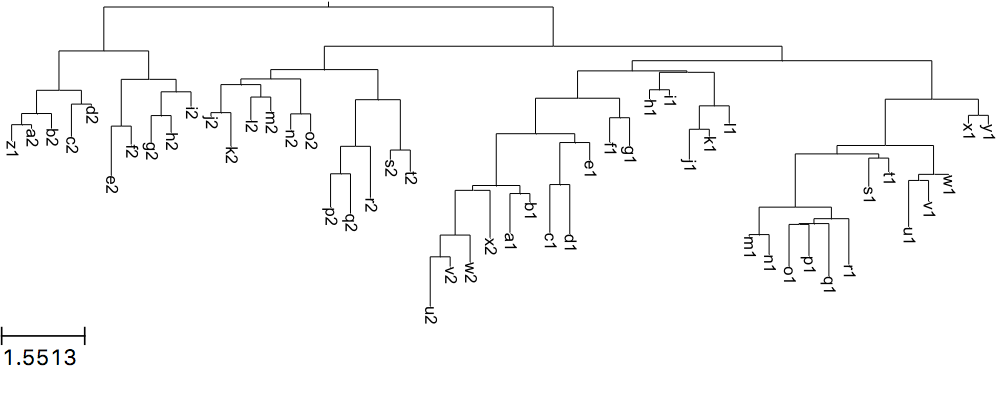

In [4]:
ts = ete3.TreeStyle()
ts.rotation = 90
fixed_tree.render("%%inline", tree_style=ts, w=1000)

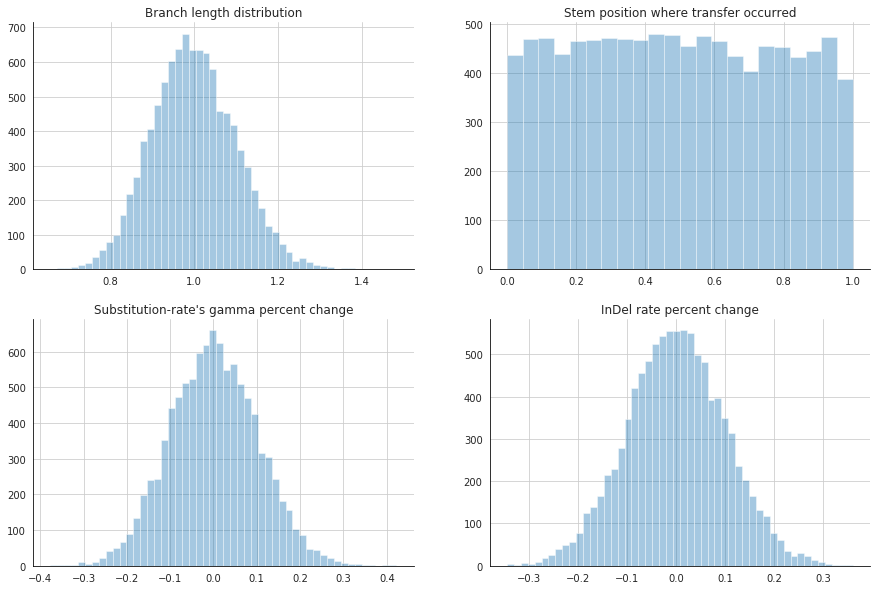

In [5]:
with pm.Model() as model:
#    alpha = 1/np.mean([node.dist for node in fixed_tree.traverse()
#                       if not node.is_root()])
    br_length_scale   = pm.Gamma('br_length_scale', 100, 100)
    point_of_transfer = pm.Uniform('point_of_transfer', lower=0, upper=1)
    subst_rate_change = pm.Normal('substitution_rate', mu=0, sigma=0.1)
    indel_rate_change = pm.Normal('indel_rate',        mu=0, sigma=0.1)

with sns.axes_style('whitegrid', rc={'axes.spines.top':   False,
                                 'axes.spines.right': False,
                                 'axes.edgecolor': 'k'}):
    fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
    
    sample   = br_length_scale.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[0, 0])
    axs[0, 0].set_title('Branch length distribution')
    
    sample   = point_of_transfer.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[0, 1])
    axs[0, 1].set_title('Stem position where transfer occurred')
    
    sample   = subst_rate_change.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[1, 0])
    axs[1, 0].set_title("Substitution-rate's gamma percent change")
    
    sample   = indel_rate_change.random(size=10000)
    sns.distplot(sample, kde=False, ax=axs[1, 1])
    axs[1, 1].set_title('InDel rate percent change');

In [6]:
seed = 12345
np.random.seed(seed)
random.seed(   seed)
tree         = fixed_tree.copy()

#
# starting evolutionary model
root = next(tree.traverse())
root.name = '#model1_'
root.add_feature('evol_model', 'model1')
root.add_feature('gamma',   1)
root.add_feature('indel',   0.05)
root.add_feature('aa_freq', [0.079066, 0.055941, 0.041977, 0.053052, 
                             0.012937, 0.040767, 0.071586, 0.057337,
                             0.022355, 0.062157, 0.099081, 0.064600,
                             0.022951, 0.042302, 0.044040, 0.061197,
                             0.053287, 0.012066, 0.034155, 0.069146])
evol_models  = {
    root.evol_model:{
        'gamma':  root.gamma,
        'indel':  root.indel,
        'aa_freq':root.aa_freq
    }
}
model_count  = 1
for node in tree.traverse():

    if node.is_root():
        continue
    
    changed_gamma = False
    changed_indel = False
    changed_freq  = False
    for ancestor in node.get_ancestors():
        if 'evol_model' in ancestor.features:
            current_active_model_node = ancestor.copy()
            break
    
    if random.random() <= 0.5:
        gamma         = current_active_model_node.gamma + subst_rate_change.random() * current_active_model_node.gamma
        changed_gamma = True
    
    if random.random() <= 0.2:
        indel         = current_active_model_node.indel + indel_rate_change.random() * current_active_model_node.indel
        changed_indel = True
        
    if random.random() <= 0.2:
        aa_freq           = deepcopy(current_active_model_node.aa_freq) 
        exchanged_indices = random.sample(range(20), 2)
        aa_freq[exchanged_indices[0]], aa_freq[exchanged_indices[1]] = aa_freq[exchanged_indices[1]], aa_freq[exchanged_indices[0]]
        changed_freq      = True
    
    if changed_gamma or changed_indel or changed_freq:
        model_count += 1
        node.name   += f'#model{model_count}_'
        node.add_feature('evol_model', f'model{model_count}')
        if changed_gamma:
            node.add_feature('gamma', gamma)
        else:
            node.add_feature('gamma', current_active_model_node.gamma)
            
        if changed_indel:
            node.add_feature('indel', indel)
        else:
            node.add_feature('indel', current_active_model_node.indel)
            
        if changed_freq:
            node.add_feature('aa_freq',   aa_freq)
        else:
            node.add_feature('aa_freq', current_active_model_node.aa_freq)
        
        evol_models[f'model{model_count}'] = {
            'gamma':  node.gamma,
            'indel':  node.indel,
            'aa_freq':node.aa_freq
        }
    else:
        node.name   += f'#{current_active_model_node.evol_model}_'

In [7]:
ts = ete3.TreeStyle()
ts.show_branch_length = True

if not os.path.isdir('trees'):
    os.mkdir('trees')
    
seed = 12345
np.random.seed(seed)
random.seed(   seed)

taxa         = tree.get_leaf_names()
topologies   = [tree.copy()]
topology_ids = set(tree.get_topology_id())
with cd('trees'):
    tree.render(file_name ="tree_%i.png" % len(topologies), 
                dpi       =100, 
                w         =500, 
                units     ='px', 
                tree_style=ts)

while len(topologies) < 50:
    starting_tree = tree.copy()
    
    pruned_node    = random.choice([node for node in tree.traverse()
                                    if tree.get_distance(node, topology_only=True) > 0]).copy()
    pruned_node.dist *= br_length_scale.random()
    
    tree.prune( set( taxa ).difference( pruned_node.get_leaf_names() ), 
               preserve_branch_length=True )

    source = random.choice([node for node in tree.traverse()
                            if not node.is_root()])

    source.add_sister(pruned_node)
    tree.resolve_polytomy()

    topology_id = tree.get_topology_id()
    if topology_id in topology_ids:
        tree = starting_tree.copy()
        continue
    
    if pruned_node.is_leaf():
        recipient = tree.get_leaves_by_name(pruned_node.name)[0]
    else:
        recipient = tree.get_common_ancestor(pruned_node.get_leaf_names())
    parent    = recipient.get_ancestors()[0]
    donor     = recipient.get_sisters()[0]
    
    parent.name = parent.get_ancestors()[0].name

    proportion  = point_of_transfer.random()
    parent.dist = donor.dist * proportion
    donor.dist -= donor.get_ancestors()[0].dist

    parent.img_style[   'size']    = 0
    donor.img_style[    'size'   ] = 5
    donor.img_style[    'fgcolor'] = 'red'
    recipient.img_style['size'   ] = 5
    recipient.img_style['fgcolor'] = 'blue'
    
    topology_ids.add(topology_id)
    topologies.append(tree.copy())
    with cd('trees'):
        tree.render(file_name ="tree_%i.png" % len(topologies), 
                    dpi       =100, 
                    w         =500, 
                    units     ='px', 
                    tree_style=ts)

    donor.img_style['size']        = 0
    recipient.img_style['size']    = 0

In [8]:
indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - gene distance metric project                    //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

'''

for model_name, model_data in evol_models.items():
    gamma = model_data['gamma']
    indel = model_data['indel']
    aa_freq = ' '.join([f'{freq:.5f}' for freq in model_data['aa_freq']])
    indelible_conf += f'''\
[MODEL] {model_name}   [submodel]  LG                         // LG
                 [rates]     0 {gamma} 10                // pinv=0, alpha=1.3, discrete gamma categories=4
                 [statefreq]
                    {aa_freq}
                 [indelmodel]   POW  1.7 500            // Power law insertion/deletion length distribution (a=1.7)
                 [indelrate]    {indel}
\n'''

In [9]:
indelible_tree_exert      = '[TREE]       {tree_name}  {newick}\n'
indelible_branch_exert    = '[BRANCHES]   {tree_name}  {newick}\n'
indelible_partition_exert = '[PARTITIONS] {partition_name} [{tree_name} {branch_name} 300]\n'
indelible_evolve_exert    = '             {partition_name}  1   {tree_name}\n'

for count, tree in enumerate(topologies, 1):
    tmp_newick = re.sub('(#model\d+_)(:\d+\.\d+)', 
                        r'\2 \1 ', 
                        tree.write(format=1, 
                                   dist_formatter='%.10f'))
    
    indelible_conf += indelible_tree_exert.format(tree_name='tree_%i'  % count,
                                                  newick   = re.sub('\s+#model\d+_\s+', 
                                                                    '', 
                                                                    tmp_newick))
    indelible_conf += indelible_branch_exert.format(tree_name='branch_%i'  % count,
                                                    newick   = re.sub(':\d+\.\d+', 
                                                                      '', 
                                                                      tmp_newick).replace(';', 
                                                                                          ' #model1 ;'
                                                                                         ).replace('_', ''))
indelible_conf += '\n'
    
for count, tree in enumerate(topologies, 1):
    indelible_conf += indelible_partition_exert.format(partition_name='partition_%i'  % count,
                                                       tree_name     ='tree_%i'       % count,
                                                       branch_name   ='branch_%i'     % count,)
indelible_conf += '\n'

indelible_conf += '[EVOLVE]     {partition_name}  1   {tree_name}\n'.format(
    partition_name='partition_1',
    tree_name     ='tree_1')
for count, tree in enumerate(topologies[1:], 2):
    indelible_conf += indelible_evolve_exert.format(partition_name='partition_%i'  % count,
                                                    tree_name     ='tree_%i'       % count)

indelible_conf = re.sub('(#model\d{1,2})(:\d+\.\d+)', 
                        r'\2 \1 ', 
                        indelible_conf)

In [10]:
with open('control.txt', 'w') as out:
    out.write(indelible_conf)

subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

0

In [11]:
if not os.path.isdir('alignments'):
    os.mkdir('alignments')

for count, tree in enumerate(topologies, 1):
    tree.write(outfile='trees/tree_%i.nwk' % count, format=5, dist_formatter='%.10f')
    shutil.copy('tree_%i_True.phy' % count, 'alignments/tree_%i.phy' % count)

In [37]:
with cd('alignments/'):
    for count in range(1, 51):
        print(count)
        with open(f'tree_{count}.phy', 'r') as phylip, \
             open(f'tree_{count}.faa', 'w') as fasta:

            for name, sequence in re.findall('^([A-z]\d+)\s+([\w-]+)\s+$', 
                                             phylip.read(), 
                                             re.M):
                sequence = sequence.replace('-', '')
                if not sequence:
                    continue
                    
                fasta.write(f'>{name}\n{sequence}\n')

        with open(f'tree_{count}.aln', 'w') as alignment:
            subprocess.call(['mafft', 
                             '--auto', 
                             '--reorder', 
                             '--quiet', 
                             '--thread', '10', 
                             f'tree_{count}.faa'], stdout=alignment)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [39]:
with cd('alignments/'):
    for count in range(7, 51):
        print(count)
        subprocess.call(['iqtree',
                         '-s', f'tree_{count}.aln',
                         '-m', 'JTT',
                         '-nt', 'AUTO',
                         '-ntmax', '10',
                         '-keep-ident',
                         '-safe',
                         '-quiet',
                         '-pre', f'tree_{count}'])

7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
